In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from interpolation import interpolation

### Notebook Summary:
**Goal:** Add geographic specificity to records without an address from disambiguation\
**Problem:** While disambiguation provides addresses for some census records, and others can be inferred based on proximately to established links, there are many records without any spatial association\
**Method:** Block numbers provide a level of specificity, but predicting them accurately hasn't been successful. By creating centroids and clustering those centroids, we can generate geographically meaningful labels that can be predicted accurately.  
**Block Centroids:** A block centroid is an (x,y) point. The coordinates are generated by the average of all x points and y points within the block respectively. The points in the block are those indicated as such from the city directory data.\
**In this notebook:** Demonstrate how block centroids are generated and what they mean geographically, specifically comparing what they look like in the context of city directory data, in comparison to the information available in the 1850 census disambiguation data

#### Get Data

In [2]:
filled_1850 = pd.read_csv("../data/dwelling_filled_sum_1850_mn.csv")
cd_1850 = pd.read_csv("../data/cd_1850_XYupdate.csv")
filled_1850.rename(columns = {"CENSUS_WARD_NUM":"Ward_Num", "CENSUS_SERIALP":"CENSUS_SERIALB", "BLOCK_NUM":"block_num", "CENSUS_REEL_HOUSEHOLD":"CENSUS_REEL", "CENSUS_SEX":"CENSUS_SEXB", "CENSUS_PAGENO_HOUSEHOLD":"CENSUS_PAGENUM", "CENSUS_RACE":"CENSUS_RACEB", "CD_X":"cd_X", "CD_Y":"cd_Y"}, inplace = True)
filled_1850.dropna(subset = ["block_num"], inplace = True)

In [3]:
ward_col = "Ward_Num"
dwelling_col = "CENSUS_DWELLING_NUM"
block_col = "block_num"
x_col = "cd_X"
y_col = "cd_Y"

In [4]:
dwellings_1850 = filled_1850.groupby([ward_col, dwelling_col], as_index = False).first()

#### Block Break Down by Ward

In [5]:
print("Number of Blocks in Each Ward, city directory")
for ward, df in cd_1850.groupby([ward_col]):
    print("Ward ",ward,": ", df[block_col].nunique(), sep = "")

Number of Blocks in Each Ward, city directory
Ward 1.0: 82
Ward 2.0: 49
Ward 3.0: 43
Ward 4.0: 49
Ward 5.0: 76
Ward 6.0: 45
Ward 7.0: 72
Ward 8.0: 63
Ward 9.0: 112
Ward 10.0: 45
Ward 11.0: 52
Ward 13.0: 47
Ward 14.0: 40
Ward 15.0: 75
Ward 16.0: 94
Ward 17.0: 70
Ward 18.0: 116
Ward 19.0: 15


In [6]:
print("Percentage of blocks represented present in disambiguation")
for dis, cd in zip(filled_1850.groupby([ward_col]), cd_1850.groupby([ward_col])):
    print("Ward ",dis[0],": ", round(dis[1][block_col].nunique()/cd[1][block_col].nunique(), 2), sep = "")

Percentage of blocks represented present in disambiguation
Ward 1: 0.83
Ward 2: 0.78
Ward 3: 0.88
Ward 4: 0.92
Ward 5: 0.97
Ward 6: 0.93
Ward 7: 0.99
Ward 8: 0.97
Ward 9: 0.92
Ward 10: 1.0
Ward 11: 0.94
Ward 13: 0.98
Ward 14: 0.95
Ward 15: 0.93
Ward 16: 0.79
Ward 17: 0.91
Ward 18: 0.75
Ward 19: 0.2


#### Making Block Centroids

let's try constructing a centroid for each block based on the city directory,
with the goal of using that in the loss function for the block number prediction model
And hopefully help with avoiding skewing the centroids based on what matches in the disambiguation

In [7]:
#Create map of wards, blocks within wards, and their corresponding centroids
block_centroids = {ward:{block:interpolation.make_centroid(df_block[x_col], df_block[y_col]) for block, df_block in df.groupby(block_col)} for ward,df in cd_1850.groupby(ward_col)}

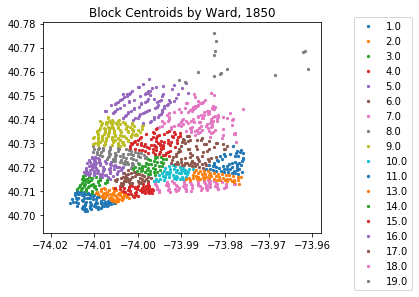

In [8]:
for key in block_centroids.keys():
    plt.scatter([value[0] for value in block_centroids[key].values()], [value[1] for value in block_centroids[key].values()], label = key, s = 5)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.tight_layout()
plt.title("Block Centroids by Ward, 1850")
plt.show()

Now there are two aspects left of this, one is to construct bins (I think I'll do this first) the next is to change the loss function of the model we use to best accomodate this revision.

### Binning blocks based on centroid

Concept: Currently, we have a situation where we don't have a lot of data for blocks, either in the city directory or in the disambiguation output. For example, there are some blocks with only one record. By binning the data we'll hopefully be able to label records with some level of geographical location and a much greater level of accuracy. Hopefully afterwards, work can be done to narrow things down further. The goal of this work is to give most dwellings in 1850 some level of geographic location within wards.

Some things to keep in mind:
- Wards are different, there will be some wards where we can assign geographic locations with much greater granularity than others
- Wards are shaped differently, this might mean something in what binning looks like
- Centroids may mean different things depending on what a block looks like

#### What centroids represent
Let's select some blocks and look at the location of the centroid in comparison to all the points within them
#### City Directory Data

In [9]:
def centroid_vis(ward, block, centroid, cd):
    plt.scatter(centroid[ward][block][0],centroid[ward][block][1], label = "centroid", s = 10)
    df = cd[(cd["Ward_Num"] == ward) & (cd["block_num"] == block)]
    plt.scatter(df.cd_X, df.cd_Y, label = "block", alpha = 0.5, s = 5)
    plt.legend()
    plt.title("Centroid and known dwellings Ward "+str(ward)+ " Block "+ str(block)+", 1850")
    plt.tight_layout()
    plt.show()
    print("Total known dwellings in block:", len(df))

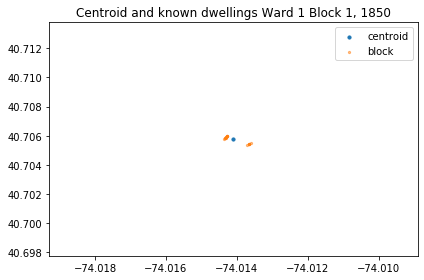

Total known dwellings in block: 19


In [10]:
centroid_vis(1, 1, block_centroids, cd_1850)

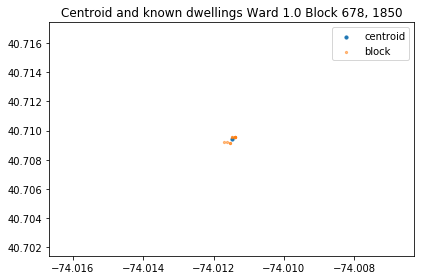

Total known dwellings in block: 11


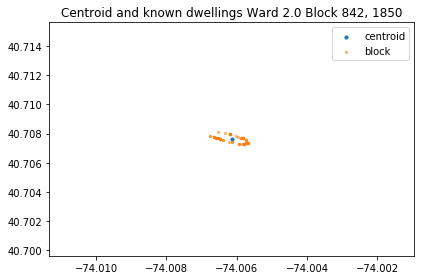

Total known dwellings in block: 74


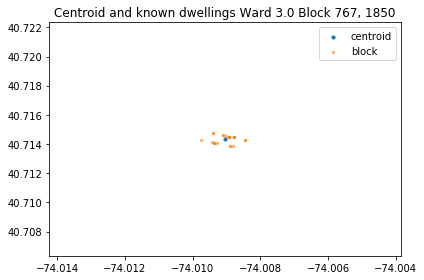

Total known dwellings in block: 24


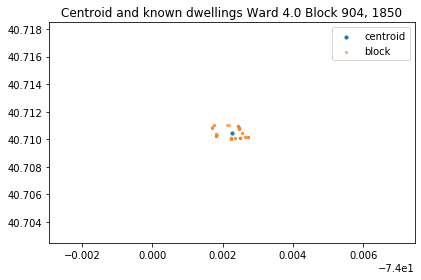

Total known dwellings in block: 44


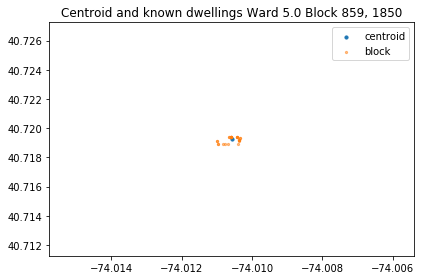

Total known dwellings in block: 30


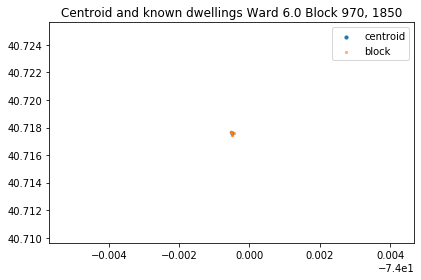

Total known dwellings in block: 11


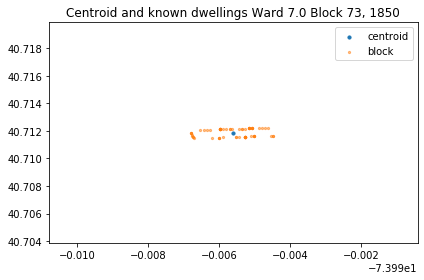

Total known dwellings in block: 70


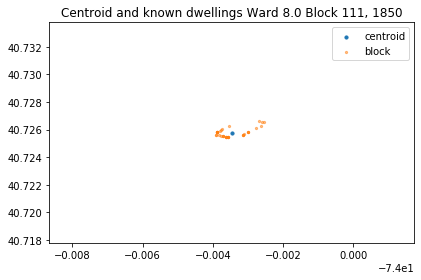

Total known dwellings in block: 37


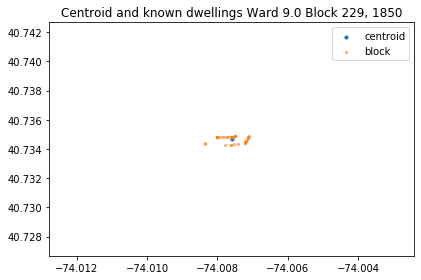

Total known dwellings in block: 38


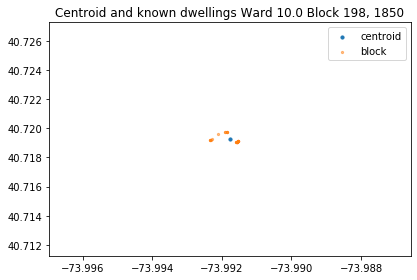

Total known dwellings in block: 27


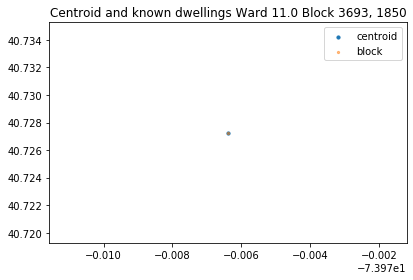

Total known dwellings in block: 1


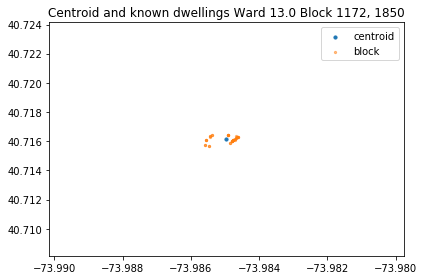

Total known dwellings in block: 42


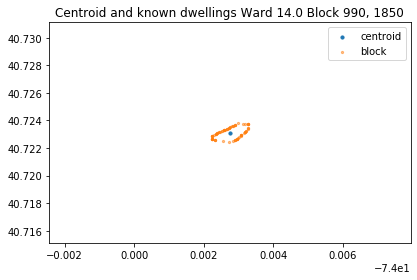

Total known dwellings in block: 76


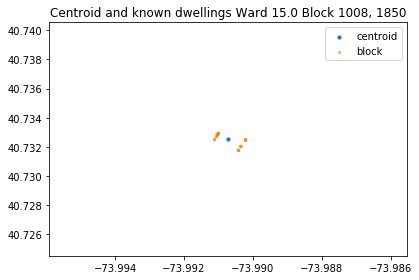

Total known dwellings in block: 22


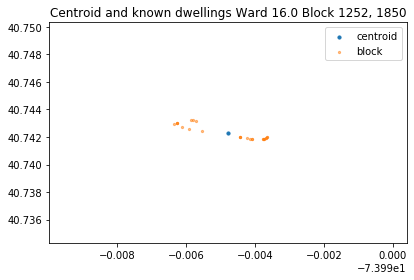

Total known dwellings in block: 25


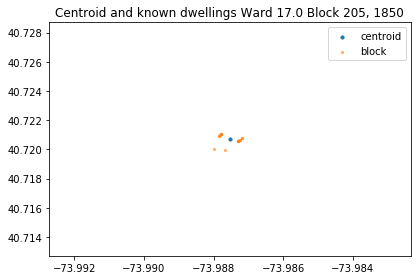

Total known dwellings in block: 16


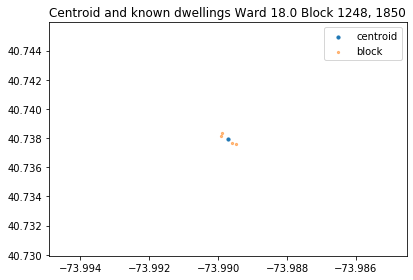

Total known dwellings in block: 4


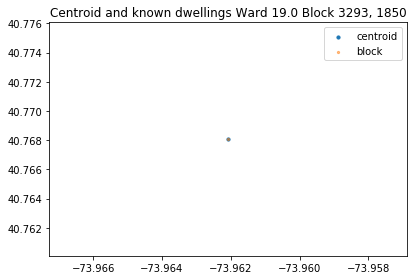

Total known dwellings in block: 1


In [11]:
for ward in block_centroids.keys():
    block = np.random.choice(cd_1850[cd_1850[ward_col] == ward][block_col].unique())
    centroid_vis(ward, block, block_centroids, cd_1850)

The sanity check holds, in that the centroid appears to be pretty representative of the geographical location of the block, that is, it doesn't look like there are any outliers or unexpected outcomes from what we've done (which is as expected given how blocks are defined).

#### Disambiguated Census Data
Look at what block centroids represent in the context of available data for that block in the 1850 disambiguation 

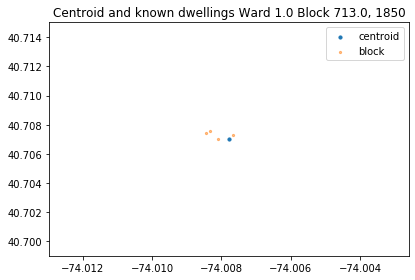

Total known dwellings in block: 4


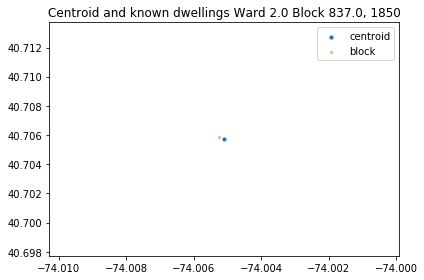

Total known dwellings in block: 1


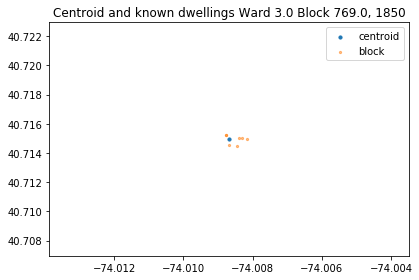

Total known dwellings in block: 7


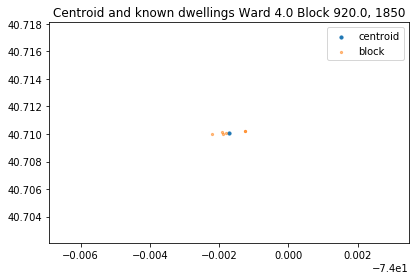

Total known dwellings in block: 6


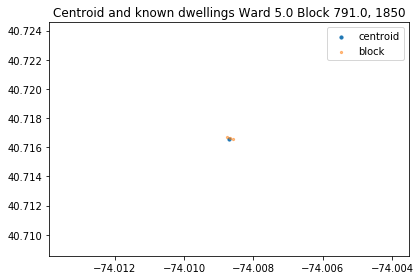

Total known dwellings in block: 3


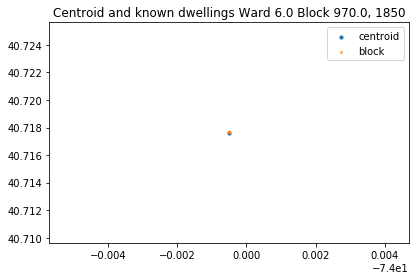

Total known dwellings in block: 4


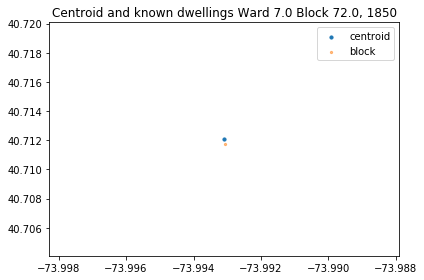

Total known dwellings in block: 1


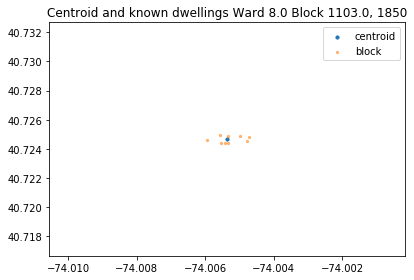

Total known dwellings in block: 9


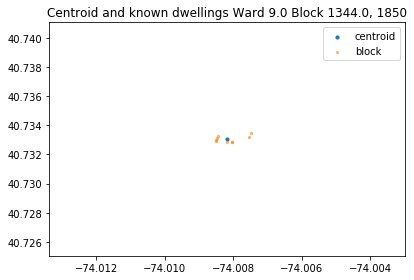

Total known dwellings in block: 9


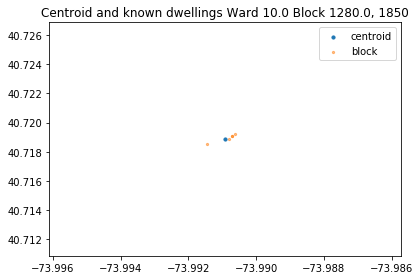

Total known dwellings in block: 5


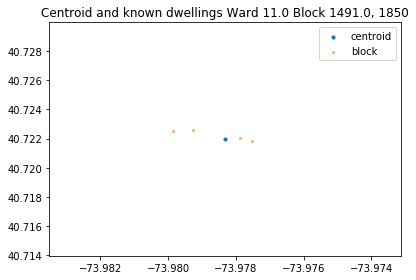

Total known dwellings in block: 4


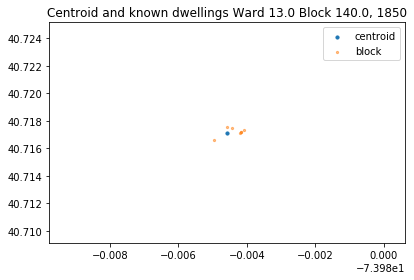

Total known dwellings in block: 7


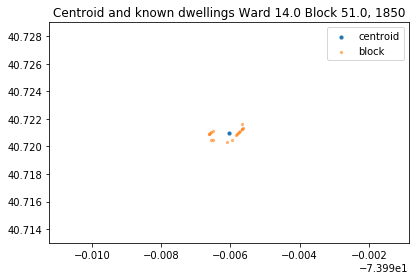

Total known dwellings in block: 18


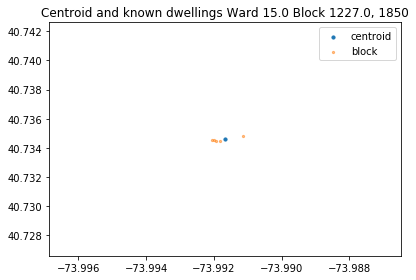

Total known dwellings in block: 5


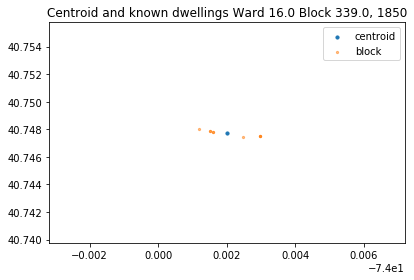

Total known dwellings in block: 9


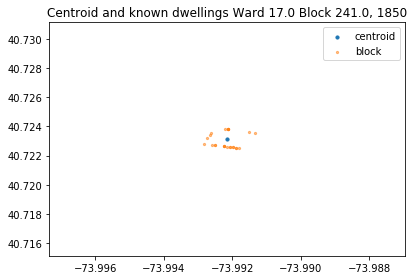

Total known dwellings in block: 25


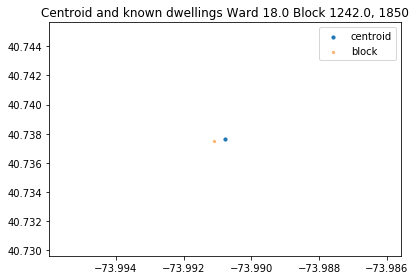

Total known dwellings in block: 1


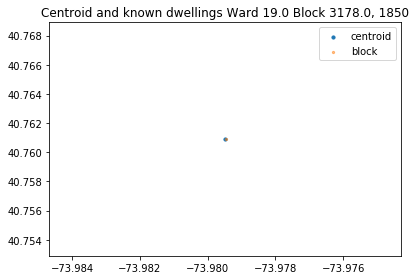

Total known dwellings in block: 1


In [12]:
dwellings_1850 = filled_1850.groupby([ward_col, dwelling_col], as_index = False).first()
for ward in block_centroids.keys():
    block = np.random.choice(dwellings_1850[dwellings_1850[ward_col] == ward][block_col].unique())
    centroid_vis(ward, block, block_centroids, dwellings_1850)

This also seems to support the idea that centroids will work reasonably even though all blocks/missing points aren't represented within the disambiguation

#### Binning approaches
The most obvious approach is clustering let's look at a few clustering approaches that may make sense here

Things to keep in mind:
- Our true goal is to create clusters of centroids (really blocks) that have as much data as possible while incorporating as few blocks as possible to provide as much granularity as we can
- That being said, starting with larger clusters may not be a bad idea

Clustering Algorithms:
- Kmeans: centroid based clusters (tune number of clusters)
- Hierarchical: clusters based on hierarchical structure
- Density based: clusters areas of high density (tune epsilon, number of neighbors)

Because the blocks themselves don't really have a hierarichical structure within wards,  kmeans or a density based algorithm (hdbscan) makes the most sense

Could we consider/explore clustering the data itself?
- a little hesitant because guaging how useful any potential cluster would be is more difficult here I think?

Should the clustering happen on the city directory data or the census data?
- Let's start with the city directory data for clustering so that clusters that don't show up in the disambiguation are part of the clustering